# Model vulnerability analysis

# scenario discovery

In [8]:
from ema_workbench.analysis import prim
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from ema_workbench import ema_logging, MultiprocessingEvaluator
from ema_workbench import Model, RealParameter, ScalarOutcome, CategoricalParameter, IntegerParameter, BooleanParameter
from ema_workbench.em_framework.samplers import sample_uncertainties
# from ema_workbench.em_framework.evaluators import MC
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

# dike_model, planning_steps = get_model_for_problem_formulation(5)

from ema_workbench.util.utilities import load_results

results = load_results('./martijnmc10pol1000scen.tar.gz')

[MainProcess/INFO] results loaded succesfully from /home/jovyan/work/final assignment/martijnmc10pol1000scen.tar.gz


In [3]:
# do something with the results to make them applicable (maybe)
experiments, outcomes = results

data = pd.DataFrame.from_dict(outcomes)

dam_list = data.filter(like='Damage').columns
# print(data.filter(like='Damage').columns)
data['total-damage'] = data[dam_list].sum(axis=1)
data.drop(columns=dam_list, inplace=True)
death_list = data.filter(like='Deaths').columns
data['total-death'] = data[death_list].sum(axis=1)
data.drop(columns=death_list, inplace=True)
invest_list = data.filter(like='Investment').columns
data['total-RaisingDike-cost'] = data[invest_list].sum(axis=1)
data.drop(columns=invest_list, inplace=True)
rfr_list = data.filter(like='RfR').columns
data['total-RfR-cost'] = data[rfr_list].sum(axis=1)
data.drop(columns=rfr_list, inplace=True)
evac_list = data.filter(like='Evacuation').columns
data['total-evacuation-cost'] = data[evac_list].sum(axis=1)
data.drop(columns=evac_list, inplace=True)

In [60]:
experiments.head(5)

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,48.0,188.292656,10.0,0.919175,285.899843,1.5,0.013483,198.974353,1.5,0.423934,...,4.0,5.0,9.0,1.0,10.0,10.0,2.0,0,0,dikesnet
1,63.0,212.679167,1.0,0.177899,298.185526,10.0,0.942886,123.165919,10.0,0.873936,...,4.0,5.0,9.0,1.0,10.0,10.0,2.0,1,0,dikesnet
2,11.0,97.453467,1.0,0.189545,333.759324,1.0,0.567906,327.617806,1.0,0.273239,...,4.0,5.0,9.0,1.0,10.0,10.0,2.0,2,0,dikesnet
3,114.0,81.908208,1.0,0.859194,57.641979,10.0,0.417337,190.770156,10.0,0.687790,...,4.0,5.0,9.0,1.0,10.0,10.0,2.0,3,0,dikesnet
4,123.0,66.741443,1.5,0.929071,290.443386,1.0,0.320991,232.021677,1.5,0.456173,...,4.0,5.0,9.0,1.0,10.0,10.0,2.0,4,0,dikesnet


### "Death"

When the decision maker is interested in the number of casualties

In [73]:
x_death =  experiments.iloc[:, 0: 48]
y_death = data['total-death'] > 0.1 # As the casualities are abnormally small, this thereshold is set as 0.1

In [21]:
np.sum(data['total-death'] > 0.1)

27677

[MainProcess/INFO] 100000 points remaining, containing 3822 cases of interest
[MainProcess/INFO] mean: 0.3752955082742317, mass: 0.05076, coverage: 0.49843014128728413, density: 0.3752955082742317 restricted_dimensions: 3


<function matplotlib.pyplot.show(*args, **kw)>

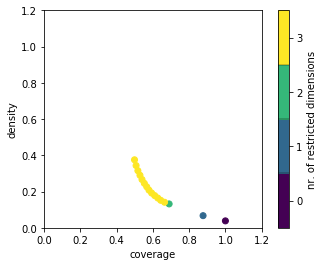

In [77]:
prim_alg = prim.Prim(x_death, y_death, threshold=0.3, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()

plt.show

In [78]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage     0.53977
density     0.266469
id                11
mass         0.07742
mean        0.266469
res_dim            3
Name: 11, dtype: object

             box 11                                           
                min       max                        qp values
0_RfR 0    0.000000  0.500000   [-1.0, 6.711622290122313e-259]
A.3_pfail  0.000013  0.381682  [-1.0, 1.0818752897157847e-217]
0_RfR 1    0.500000  1.000000   [3.817334129338881e-263, -1.0]



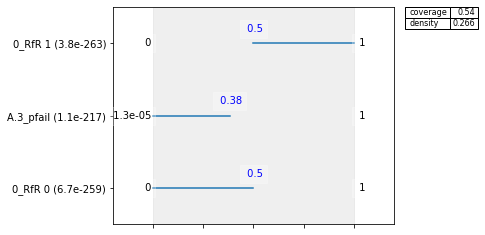

In [79]:
# select any to inspect (currently 21)
box1.inspect(11)
box1.inspect(11, style='graph')

plt.show()

C:\Users\teres\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\teres\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


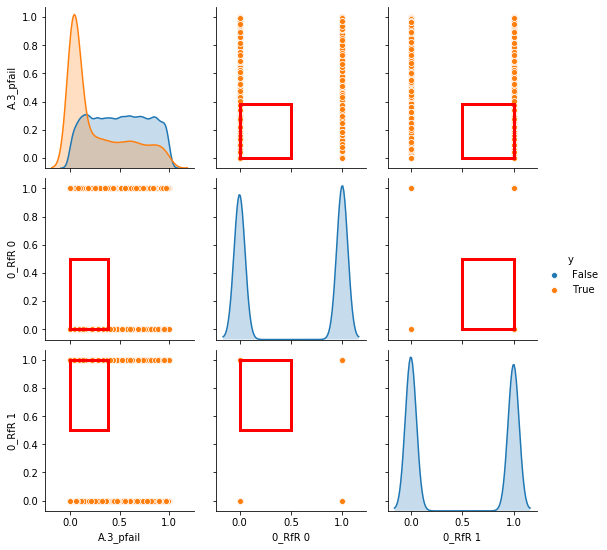

In [80]:
box1.select(11)
fig = box1.show_pairs_scatter()
plt.show()

##### The scenario discovery dosen't seem to provide any useful info. 

# subspace partitioning

In [29]:
x0 = experiments.drop(['scenario','policy'], axis = 1, inplace = False)

In [30]:
# Merge some outcomes for easy plotting
data = pd.DataFrame.from_dict(outcomes)

dam_list = data.filter(like='Damage').columns
# print(data.filter(like='Damage').columns)
data['total-damage'] = data[dam_list].sum(axis=1)
data.drop(columns=dam_list, inplace=True)
death_list = data.filter(like='Deaths').columns
data['total-death'] = data[death_list].sum(axis=1)
data.drop(columns=death_list, inplace=True)
invest_list = data.filter(like='Investment').columns
data['total-RaisingDike-cost'] = data[invest_list].sum(axis=1)
data.drop(columns=invest_list, inplace=True)
rfr_list = data.filter(like='RfR').columns
data['total-RfR-cost'] = data[rfr_list].sum(axis=1)
data.drop(columns=rfr_list, inplace=True)
evac_list = data.filter(like='Evacuation').columns
data['total-evacuation-cost'] = data[evac_list].sum(axis=1)
data.drop(columns=evac_list, inplace=True)

In [40]:
data['TotalCost'] = data['total-RaisingDike-cost'] + data['total-RfR-cost'] + data['total-evacuation-cost']

In [41]:
y0 = data

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


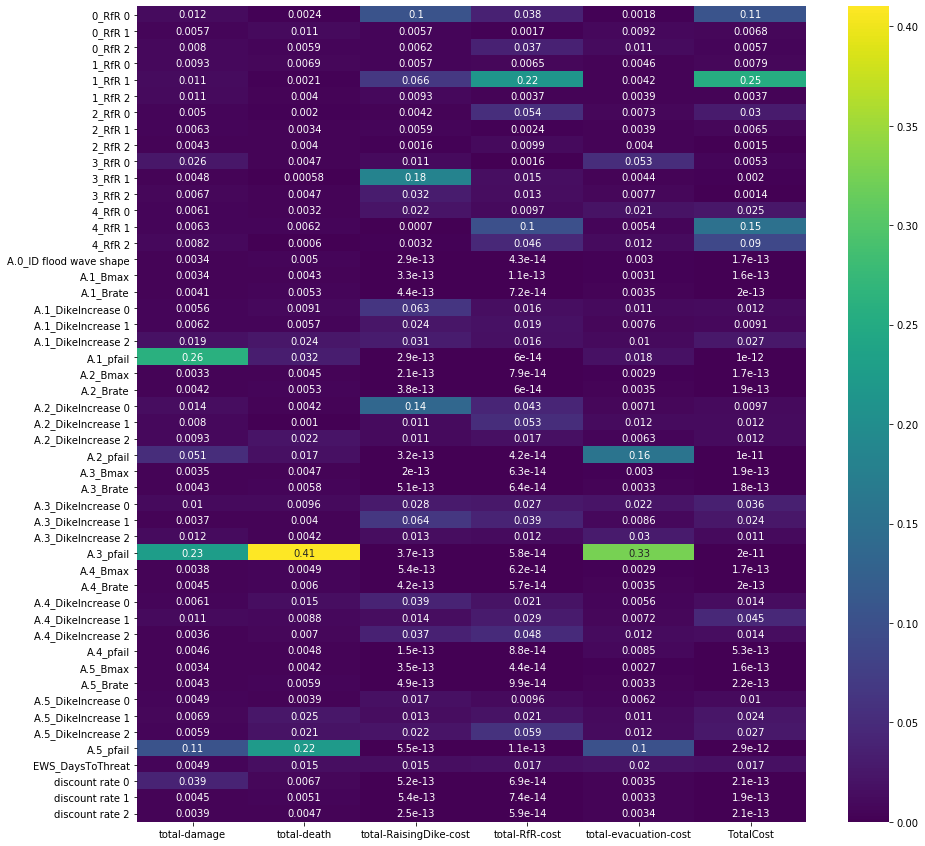

In [43]:
# from ema_workbench.analysis import feature_scoring
import seaborn as sns


fs = feature_scoring.get_feature_scores_all(x0, y0)
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

* The total damage is related to the dike failure probabilities, especially for A1 and A3.
* Regarding the casualties, it is highly determined by the dike fail probability of A3 and A5. 
* RfR at the beginning for location 1 (dike ring 2 ) would influence most of the total cost


In [44]:
fig.savefig('FeatureScoring.png')

# sensitivity analysis 
#### First to look at the effects of uncertainty fators

In [9]:
dike_model, planning_steps = get_model_for_problem_formulation(5)

In [10]:
from SALib.analyze import sobol
from ema_workbench import Policy
from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench import (MultiprocessingEvaluator, SequentialEvaluator)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from ema_workbench.util.utilities import load_results

results = load_results('./sobolnopol4000scen.tar.gz')

[MainProcess/INFO] results loaded succesfully from /home/jovyan/work/final assignment/sobolnopol4000scen.tar.gz


In [11]:
experiments, outcomes = results

data = pd.DataFrame.from_dict(outcomes)

dam_list = data.filter(like='Damage').columns
# print(data.filter(like='Damage').columns)
data['total-damage'] = data[dam_list].sum(axis=1)
data.drop(columns=dam_list, inplace=True)
death_list = data.filter(like='Deaths').columns
data['total-death'] = data[death_list].sum(axis=1)
data.drop(columns=death_list, inplace=True)
invest_list = data.filter(like='Investment').columns
data['total-RaisingDike-cost'] = data[invest_list].sum(axis=1)
data.drop(columns=invest_list, inplace=True)
rfr_list = data.filter(like='RfR').columns
data['total-RfR-cost'] = data[rfr_list].sum(axis=1)
data.drop(columns=rfr_list, inplace=True)
evac_list = data.filter(like='Evacuation').columns
data['total-evacuation-cost'] = data[evac_list].sum(axis=1)
data.drop(columns=evac_list, inplace=True)

In [12]:
from SALib.analyze import sobol
from ema_workbench import (MultiprocessingEvaluator, SequentialEvaluator)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

uncertainties = []
for uncertainty in dike_model.uncertainties:
    uncertainties.append(uncertainty)

#with SequentialEvaluator(dike_model) as evaluator:
    #sa_results = evaluator.perform_experiments(scenarios = 50 , 
                                               #uncertainty_sampling='sobol')

In [93]:
# experiments, outcomes = sa_results
# outcomes = {key:outcomes[key][:,0,:] for key in outcomes.keys()}

In [13]:
problem = get_SALib_problem(uncertainties)

In [14]:
data['TotalCost'] = data['total-RaisingDike-cost'] + data['total-RfR-cost'] + data['total-evacuation-cost']
data.head()

,total-damage,total-death,total-RaisingDike-cost,total-RfR-cost,total-evacuation-cost,TotalCost
0,2.534728e+09,4.058596,0,0.0,0.0,0.0
1,2.530618e+09,4.035948,0,0.0,0.0,0.0
2,2.534576e+09,4.058143,0,0.0,0.0,0.0
3,2.534728e+09,4.058596,0,0.0,0.0,0.0
4,2.490785e+09,4.021415,0,0.0,0.0,0.0


In [15]:
import numpy as np

Si_damage = sobol.analyze(problem, np.array(data['total-damage']),
                   calc_second_order=True, print_to_console=False)

Si_death = sobol.analyze(problem, np.array(data['total-death']),
                   calc_second_order=True, print_to_console=False)

Si_cost = sobol.analyze(problem, np.array(data['TotalCost']),
                   calc_second_order=True, print_to_console=False)


/opt/conda/envs/python38/lib/python3.8/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()


In [16]:
Si_damage_filter = {k:Si_damage[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_damage_df = pd.DataFrame(Si_damage_filter, index = problem['names'])
# Si_damage_df

Si_death_filter = {k:Si_death[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_death_df = pd.DataFrame(Si_death_filter, index = problem['names'])
# Si_damage_df

Si_cost_filter = {k:Si_cost[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_cost_df = pd.DataFrame(Si_cost_filter, index = problem['names'])
# Si_cost_df

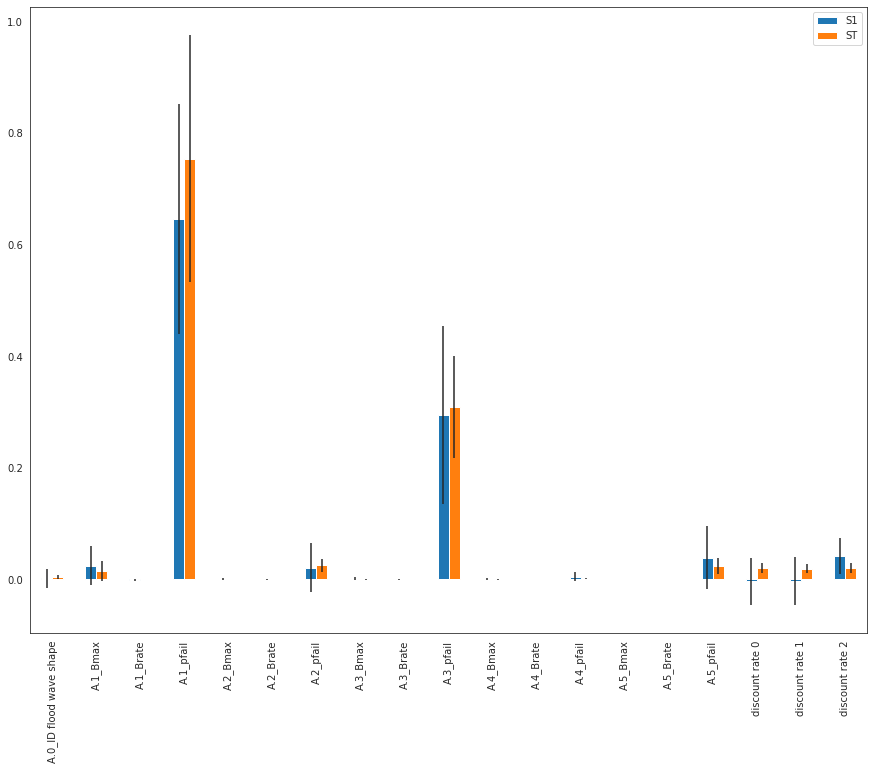

In [17]:
import seaborn as sns

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_damage_df[['S1','ST']]
err = Si_damage_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(15,15)
fig.subplots_adjust(bottom=0.3)
plt.show()

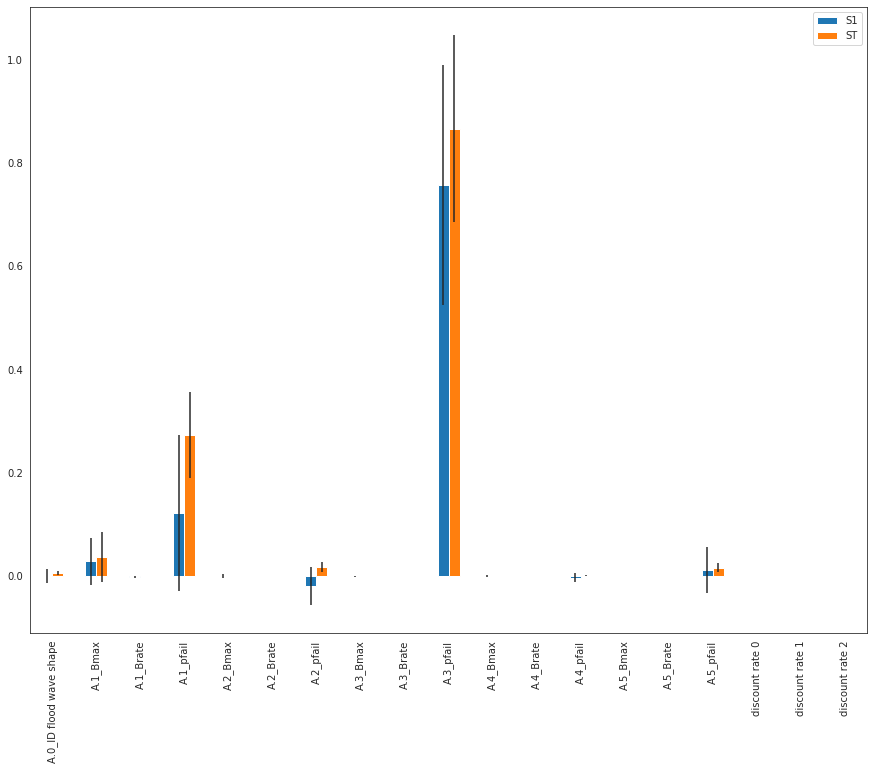

In [19]:
import seaborn as sns

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_death_df[['S1','ST']]
err = Si_death_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(15,15)
fig.subplots_adjust(bottom=0.3)
plt.show()

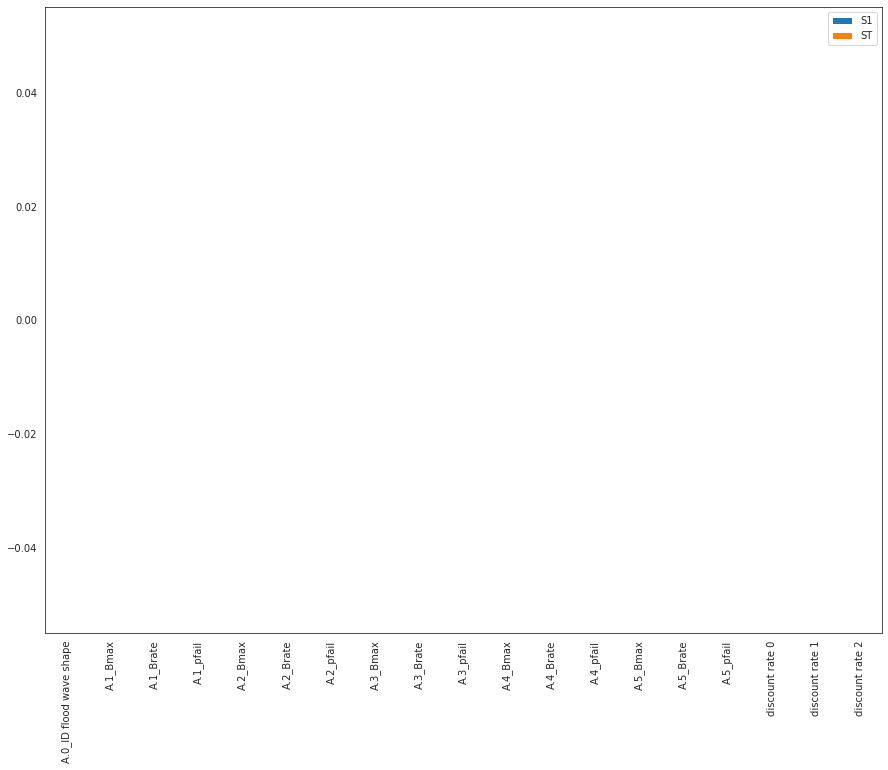

In [21]:
import seaborn as sns

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_cost_df[['S1','ST']]
err = Si_cost_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(15,15)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### To look at the effects of policy levers

In [22]:
dike_model, planning_steps = get_model_for_problem_formulation(5)

In [23]:
levers = []
for lever in dike_model.levers:
    levers.append(lever)

In [24]:
problem_1 = get_SALib_problem(levers)

In [25]:
import numpy as np

Si_damage_1 = sobol.analyze(problem_1, np.array(data['total-damage']),
                   calc_second_order=True, print_to_console=False)

Si_death_1 = sobol.analyze(problem_1, np.array(data['total-death']),
                   calc_second_order=True, print_to_console=False)

Si_cost_1 = sobol.analyze(problem_1, np.array(data['TotalCost']),
                   calc_second_order=True, print_to_console=False)


RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.

# extra trees

   A.0_ID flood wave shape  A.1_Bmax A.1_Brate  A.1_pfail  A.2_Bmax A.2_Brate  \
0                     29.0   60.9375       1.5   0.676758  119.6875      10.0   
1                     96.0   60.9375       1.5   0.676758  119.6875      10.0   
2                     29.0  197.1875       1.5   0.676758  119.6875      10.0   
3                     29.0   60.9375       1.5   0.676758  119.6875      10.0   
4                     29.0   60.9375       1.5   0.950195  119.6875      10.0   

   A.2_pfail  A.3_Bmax A.3_Brate  A.3_pfail  ...  A.3_DikeIncrease 0  \
0   0.045898  317.8125       1.5   0.069336  ...                 3.0   
1   0.045898  317.8125       1.5   0.069336  ...                 3.0   
2   0.045898  317.8125       1.5   0.069336  ...                 3.0   
3   0.045898  317.8125       1.5   0.069336  ...                 3.0   
4   0.045898  317.8125       1.5   0.069336  ...                 3.0   

  A.3_DikeIncrease 1  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
0               

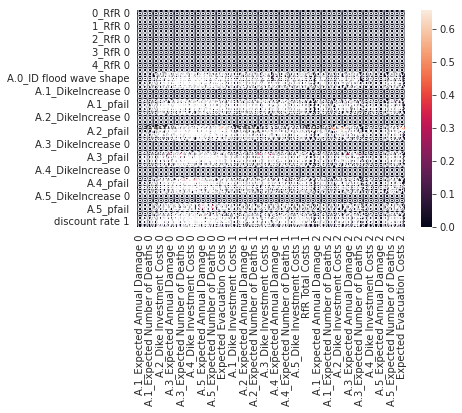

In [80]:
extra_trees_results = results

tree_experiments, tree_outcomes = extra_trees_results
# tree_outcomes = {key:tree_outcomes[key][:,0, -1] for key in tree_outcomes.keys()} # Important for printing, delete redundant array
tree_experiments = tree_experiments.drop(columns=['scenario', 'policy', 'model'], inplace=False)
print(tree_experiments.head(5))
print(tree_outcomes)
from ema_workbench.analysis import feature_scoring
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

score = feature_scoring.get_feature_scores_all(tree_experiments, tree_outcomes)
sns.heatmap(score, annot=True)
plt.show()

# sobol vs. extra trees

In [81]:
scores, p_values = feature_scoring.get_rf_feature_scores(tree_experiments,tree_outcomes['A.1_Expected Annual Damage 0'],  mode=RuleInductionType.REGRESSION, 
                                                         nr_trees=100, max_features=0.6)
scores

NameError: name 'RuleInductionType' is not defined

In [2]:
Si_df_1['ST']

NameError: name 'Si_df_1' is not defined